## 2D discrete Fourier transform and 2D discrete wavelet transform for denoising white noise

I have great interest in signal processing, so I decided to learn more along my PhD. Unfortunately, this was a part of my PhD that did not worked as I expected but it took me to other works. This is part of the extended abstract [2D discrete wavelet transform for denoising aeromagnetic data](https://library.seg.org/doi/10.1190/segam2018-2998295.1) that I presented in 2018 at the SEG conference in Anaheim, CA - USA, with some things that I presented in my PhD qualifying exam. Here are the [slides of the presentation](https://figshare.com/articles/2D_discrete_wavelet_transform_for_denoising_magnetic_data/7237643). For contextualization, there is a Disneyland in Anaheim. These techniques can be applied to any kind of data, although I applied in magnetic data, on that time. The discrete wavelet transform is used to denoise white noise and also defines the edges of an image. In this work, the filtering in Fourier domain is performed with a Buterworth filter and in wavelet domain with the hard threshold with cycle spinning.

In [32]:
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
import pywt
import copy
import pylab
import func_dft_dwt as func
from matplotlib.gridspec import GridSpec

Load the "mm model" - a famous model in Anaheim

(228, 253, 3)


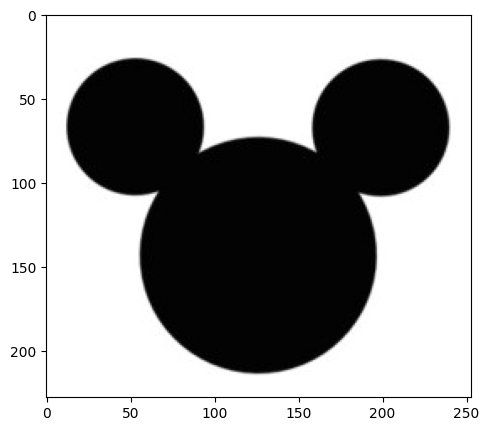

In [47]:
image = img.imread('mm_model.jpg')
#image = img.imread('D:/ECE595_UD_lab/Restoration/wiener-filter-image-restoration/lena256.jpg')

array = np.copy(image[:,:,0]) #just need one 2D array from the image

plt.figure(figsize=(5,5))
plt.imshow(array, cmap=plt.cm.gray)
plt.tight_layout()
print(image.shape)

Generate white noise and add to the initial model

In [34]:
shape_dat=np.shape(array)

sigma = 0.03
sigma2=sigma*np.max(abs(array))
noise = np.random.normal(scale=sigma2, size=(shape_dat))

data=array+noise

###  Plot the initial model, the noise and the noisy data

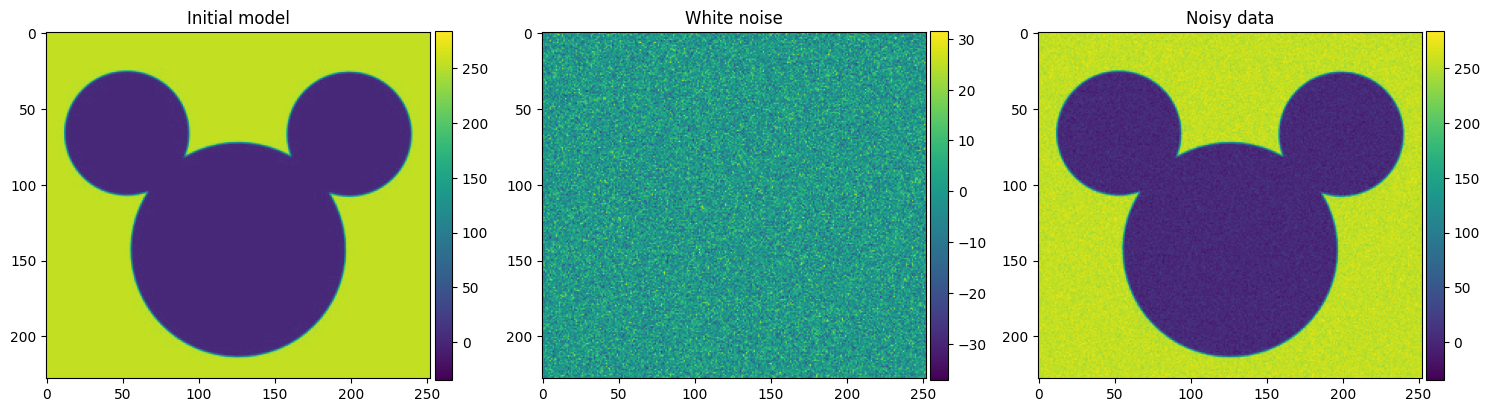

In [35]:
plt.figure(figsize=(15,5))

minplt = np.min(data)
maxplt = np.max(data)

ax=plt.subplot(1,3,1)
plt.imshow(array, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.title('Initial model')
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,2)
plt.title('White noise')
plt.imshow(noise, cmap=plt.cm.viridis)
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,3)
plt.title('Noisy data')
plt.imshow(data, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.colorbar(pad=0.01,fraction=0.043)

plt.tight_layout()

Coordinates

In [36]:
x=np.arange(0.,data.shape[0],1.)
y=np.arange(0.,data.shape[1],1.)
Y,X=np.meshgrid(y,x)

## 2D DFT

In [48]:
# Perform the 2D DFT and extend the data with a pad
anom_FFT, mask = func.fft_pad_data(data)
shape_pdat=anom_FFT.shape
# Fourier wavenumbers
u, v = func.fft_wavenumbers(X, Y, shape_dat, shape_pdat)
# Center the anomaly 
anom_FFT_shift=np.fft.fftshift(anom_FFT)
minsize=int(np.min(np.log10(abs(anom_FFT_shift))))
maxsize=int(np.max(np.log10(abs(anom_FFT_shift))))
# Draw the Butterworth filter
freq=0.15
order=4
filt=func.butter2d_lp(anom_FFT_shift.shape, freq,order)
# Filter the noisy data in Fourier domain
anom_filt_fft = anom_FFT_shift * filt
# Filtered data
filtered_fft = func.ifft_unpad_data(np.fft.ifftshift(anom_filt_fft),  mask, shape_dat)

### Plot the noisy data in Fourier domain, the Butterworth filter and the filtered data in Fourier domain

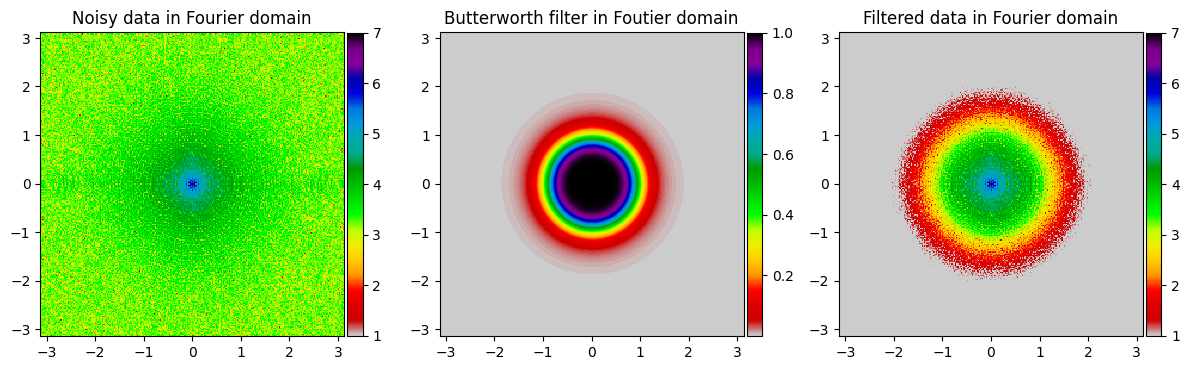

In [38]:
plt.figure(figsize=(12,5))

ax=plt.subplot(1,3,1)
plt.title('Noisy data in Fourier domain')
plt.imshow(np.log10(abs(anom_FFT_shift)),cmap=plt.cm.nipy_spectral_r,interpolation='nearest',\
           extent=[v.min(),v.max(),u.min(),u.max()],vmin=minsize,vmax=maxsize)
plt.colorbar(pad=0.01,fraction=0.047)

ax=plt.subplot(1,3,2)
plt.title('Butterworth filter in Foutier domain')
plt.imshow(filt,cmap=plt.cm.nipy_spectral_r,extent=[v.min(),v.max(),u.min(),u.max()])
plt.colorbar(pad=0.01,fraction=0.047)

ax=plt.subplot(1,3,3)
plt.title('Filtered data in Fourier domain')
plt.imshow(np.log10(abs(anom_filt_fft)),cmap=plt.cm.nipy_spectral_r,interpolation='nearest',\
           extent=[v.min(),v.max(),u.min(),u.max()],vmin=minsize,vmax=maxsize)
plt.colorbar(pad=0.01,fraction=0.047)

plt.tight_layout()

### Plot the input data, filtered data via DFT and the residuals

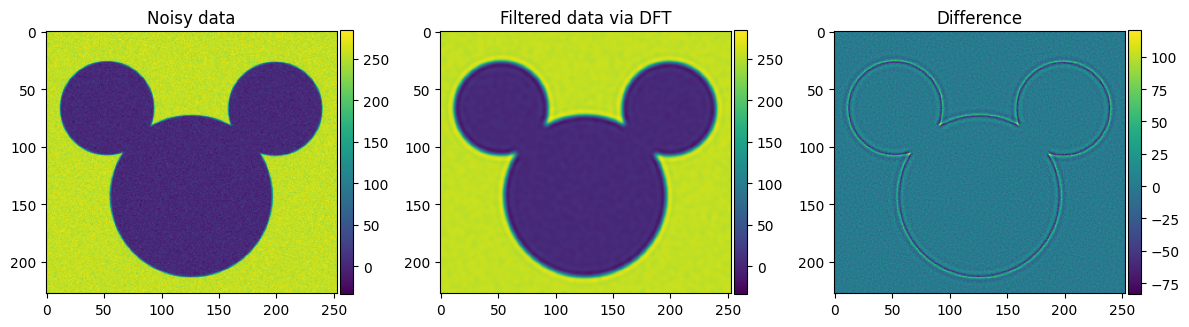

In [39]:
plt.figure(figsize=(12,5))

ax=plt.subplot(1,3,1)
plt.title('Noisy data')
plt.imshow(data, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,2)
plt.title('Filtered data via DFT')
plt.imshow(filtered_fft, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,3)
plt.title('Difference')
plt.imshow(data-filtered_fft, cmap=plt.cm.viridis)
plt.colorbar(pad=0.01,fraction=0.043)

plt.tight_layout()

## 2D DWT 

In [55]:
#define the wavelet - http://wavelets.pybytes.com/
#wav = 'coif4'
wav = 'db4'
wavelet=pywt.Wavelet(wav)
# number of scales to decompose the data
scales=2
# 2D wavelet deconposition
decomp = pywt.wavedec2(data,wav,level=scales)

### Plot the data in the discrete wavelet domain, the decomposition is performed in 2 scales

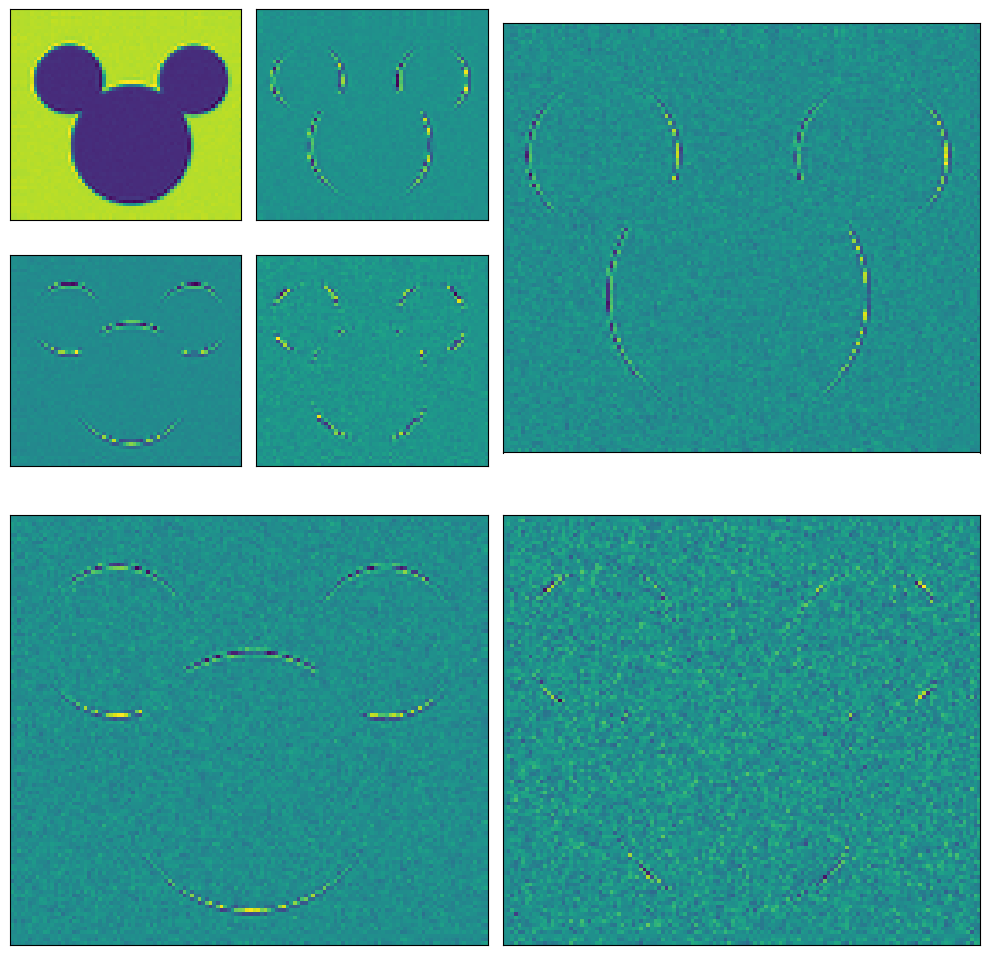

In [56]:
func.plot_wav(decomp)

### Perform the fitlering in wavelet domain with the hard threshold with cycle spinning

In [42]:
m,n=np.shape(data)
filt_dwt = np.zeros_like(data)

#Generate a set of shifts 
for i in range(0,min(m,n)):
    fS = np.roll(data,i,axis=0) #this is the circular shift for the cycle spinning, one shift per iteration
    decomp = pywt.wavedec2(fS,wav,level=scales)
    decompclean = copy.deepcopy(decomp) #safe copy
    det = np.c_[decomp[-1][:]] #finest scale
    sigma = np.median(abs(det))/0.6745  
    thresh = sigma*np.sqrt(2*np.log(len(data))) #define the threshold for filtering
    for j in range(1,len(decomp)):
        decompclean[j] = tuple(pywt.threshold(decompclean[j],thresh,'hard')) #perform the filtering
    fS = pywt.waverec2(decompclean,wav) #reconstruct the data to the original domain
    fS = np.roll(fS[:,:-1],-i,axis=0) # unshift the data
    filt_dwt = i/(i+1.0)*filt_dwt + 1.0/(i+1)*fS #finishes the cycle spinning with weighting

###  Plot the filtered data in wavelet domain

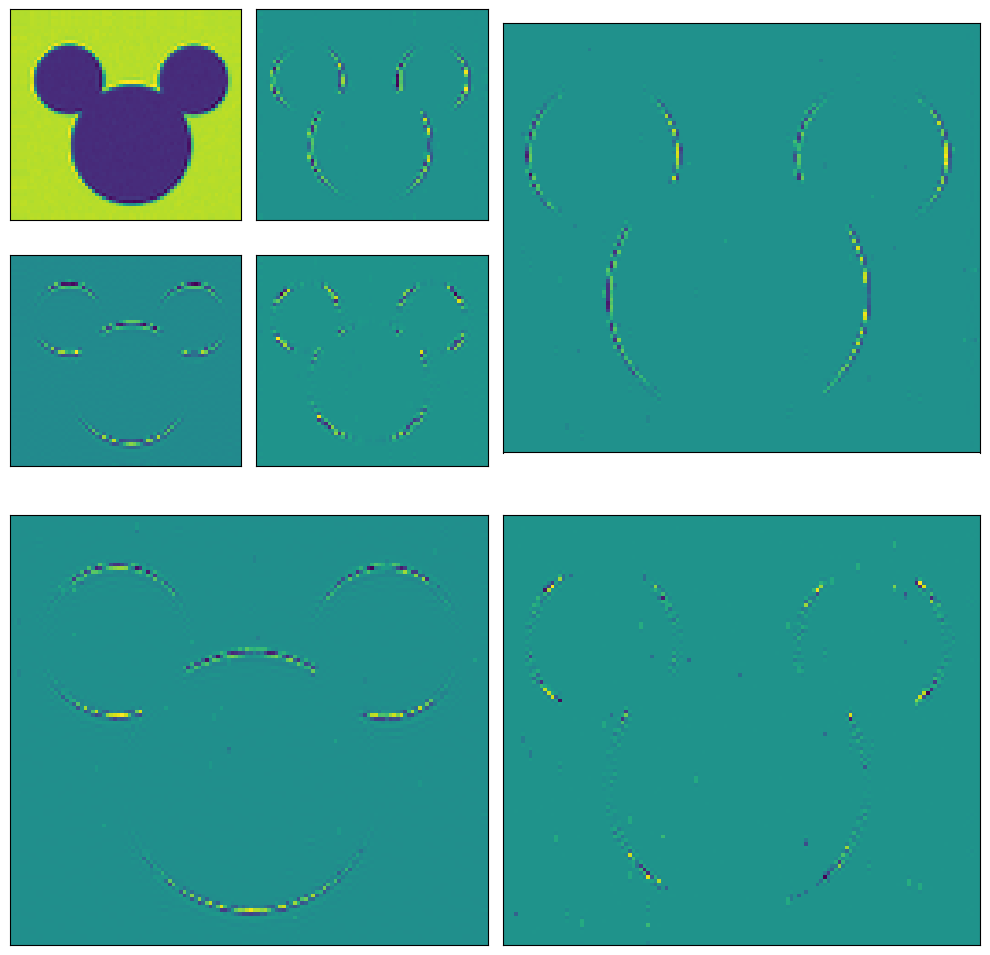

In [43]:
# 2D wavelet deconposition
decomp2 = pywt.wavedec2(filt_dwt,wav,level=scales)

func.plot_wav(decomp2)

### Plot the input data, filtered data via DFT and the residuals

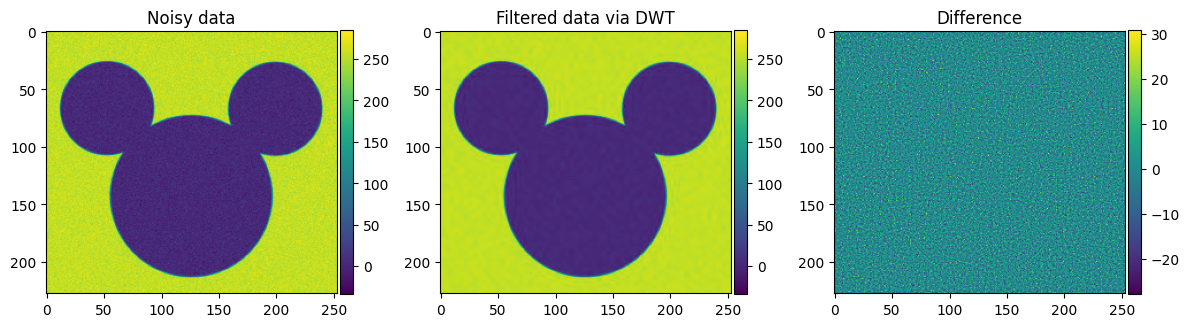

In [44]:
plt.figure(figsize=(12,5))

ax=plt.subplot(1,3,1)
plt.title('Noisy data')
plt.imshow(data, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,2)
plt.title('Filtered data via DWT')
plt.imshow(filt_dwt, cmap=plt.cm.viridis,vmin=minplt,vmax=maxplt)
plt.colorbar(pad=0.01,fraction=0.043)

ax=plt.subplot(1,3,3)
plt.title('Difference')
plt.imshow(data-filt_dwt, cmap=plt.cm.viridis)
plt.colorbar(pad=0.01,fraction=0.043)

plt.tight_layout()